In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


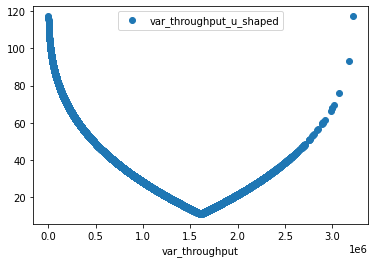

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [4]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [5]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [7]:
deception_class_weights

array([10.19282511,  0.52579227])

In [6]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [10]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [11]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [12]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [14]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=50,
                  validation_data=(X_test, y_test_rapport), 
#                   callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 2s 30ms/step - loss: 0.6932 - accuracy: 0.2767 - f1_m: 0.1950 - recall_m: 0.2079 - precision_m: 0.1990 - val_loss: 0.6939 - val_accuracy: 0.1288 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/50
72/72 [==============================] - 2s 24ms/step - loss: 0.6931 - accuracy: 0.6014 - f1_m: 0.6041 - recall_m: 0.6293 - precision_m: 0.7667 - val_loss: 0.7315 - val_accuracy: 0.1288 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/50
72/72 [==============================] - 2s 26ms/step - loss: 0.6923 - accuracy: 0.3768 - f1_m: 0.4118 - recall_m: 0.3260 - precision_m: 0.8425 - val_loss: 0.7252 - val_accuracy: 0.2608 - val_f1_m: 0.2911 - val_recall_m: 0.1763 - val_precision_m: 0.8757
Epoch 4/50
72/72 [==============================] - 2s 25ms/step - loss: 0.6854 - accuracy: 0.4086 - f1_m: 0.5013 - recall_m: 0.3557 - precision_m: 0.9033 - val_loss: 0.6282 - val_a

Epoch 32/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4750 - accuracy: 0.7559 - f1_m: 0.8357 - recall_m: 0.7413 - precision_m: 0.9647 - val_loss: 0.5741 - val_accuracy: 0.7155 - val_f1_m: 0.8288 - val_recall_m: 0.7959 - val_precision_m: 0.8657
Epoch 33/50
72/72 [==============================] - 2s 25ms/step - loss: 0.4624 - accuracy: 0.7642 - f1_m: 0.8464 - recall_m: 0.7548 - precision_m: 0.9680 - val_loss: 0.7644 - val_accuracy: 0.6165 - val_f1_m: 0.7488 - val_recall_m: 0.6611 - val_precision_m: 0.8649
Epoch 34/50
72/72 [==============================] - 2s 25ms/step - loss: 0.4587 - accuracy: 0.7611 - f1_m: 0.8389 - recall_m: 0.7437 - precision_m: 0.9688 - val_loss: 0.6364 - val_accuracy: 0.6803 - val_f1_m: 0.8019 - val_recall_m: 0.7506 - val_precision_m: 0.8627
Epoch 35/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4486 - accuracy: 0.7732 - f1_m: 0.8532 - recall_m: 0.7651 - precision_m: 0.9685 - val_loss: 0.8115 - val_accuracy: 0.5550 - va

In [15]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

(0.508179419525066, 0.5101208925061118, 0.5076017249004866, None)

In [16]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=50,
                   validation_data=(X_test, y_test_gamemove), 
#                    callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 2s 30ms/step - loss: 0.6932 - accuracy: 0.6091 - f1_m: 0.6251 - recall_m: 0.6370 - precision_m: 0.6812 - val_loss: 0.6934 - val_accuracy: 0.2375 - val_f1_m: 0.3231 - val_recall_m: 0.1955 - val_precision_m: 0.9590
Epoch 2/50
72/72 [==============================] - 2s 25ms/step - loss: 0.6934 - accuracy: 0.4300 - f1_m: 0.4288 - recall_m: 0.4137 - precision_m: 0.5730 - val_loss: 0.6863 - val_accuracy: 0.9376 - val_f1_m: 0.9675 - val_recall_m: 1.0000 - val_precision_m: 0.9372
Epoch 3/50
72/72 [==============================] - 2s 25ms/step - loss: 0.6923 - accuracy: 0.7564 - f1_m: 0.8013 - recall_m: 0.7859 - precision_m: 0.9221 - val_loss: 0.6745 - val_accuracy: 0.6271 - val_f1_m: 0.7606 - val_recall_m: 0.6355 - val_precision_m: 0.9495
Epoch 4/50
72/72 [==============================] - 2s 24ms/step - loss: 0.6844 - accuracy: 0.4261 - f1_m: 0.5572 - recall_m: 0.4082 - precision_m: 0.9507 - val_loss: 0.6878 - val_accuracy: 0.3426 - val_f1

Epoch 32/50
72/72 [==============================] - 2s 24ms/step - loss: 0.5250 - accuracy: 0.7088 - f1_m: 0.8141 - recall_m: 0.7063 - precision_m: 0.9798 - val_loss: 0.4277 - val_accuracy: 0.8052 - val_f1_m: 0.8908 - val_recall_m: 0.8490 - val_precision_m: 0.9380
Epoch 33/50
72/72 [==============================] - 2s 25ms/step - loss: 0.5362 - accuracy: 0.7402 - f1_m: 0.8358 - recall_m: 0.7398 - precision_m: 0.9763 - val_loss: 0.4575 - val_accuracy: 0.8122 - val_f1_m: 0.8949 - val_recall_m: 0.8556 - val_precision_m: 0.9396
Epoch 34/50
72/72 [==============================] - 2s 25ms/step - loss: 0.5154 - accuracy: 0.7173 - f1_m: 0.8164 - recall_m: 0.7104 - precision_m: 0.9814 - val_loss: 0.4672 - val_accuracy: 0.7674 - val_f1_m: 0.8660 - val_recall_m: 0.8036 - val_precision_m: 0.9399
Epoch 35/50
72/72 [==============================] - 2s 26ms/step - loss: 0.5172 - accuracy: 0.7103 - f1_m: 0.8148 - recall_m: 0.7074 - precision_m: 0.9804 - val_loss: 0.4739 - val_accuracy: 0.7920 - va

In [17]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.5008739011977588, 0.503144570990672, 0.2863343411676383, None)

In [18]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_reasoning), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 2s 29ms/step - loss: 0.6933 - accuracy: 0.8025 - f1_m: 0.8716 - recall_m: 0.9590 - precision_m: 0.8232 - val_loss: 0.6906 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 2/50
72/72 [==============================] - 2s 24ms/step - loss: 0.6932 - accuracy: 0.7691 - f1_m: 0.8357 - recall_m: 0.9082 - precision_m: 0.8132 - val_loss: 0.6901 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 3/50
72/72 [==============================] - 2s 23ms/step - loss: 0.6931 - accuracy: 0.7090 - f1_m: 0.7459 - recall_m: 0.8034 - precision_m: 0.7202 - val_loss: 0.7907 - val_accuracy: 0.1781 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 4/50
72/72 [==============================] - 2s 24ms/step - loss: 0.6935 - accuracy: 0.4472 - f1_m: 0.3905 - recall_m: 0.4233 - precision_m: 0.3750 - val_loss: 0.6629 - val_accuracy: 0.8

Epoch 32/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4385 - accuracy: 0.7415 - f1_m: 0.8174 - recall_m: 0.7115 - precision_m: 0.9669 - val_loss: 0.7382 - val_accuracy: 0.6733 - val_f1_m: 0.7947 - val_recall_m: 0.7735 - val_precision_m: 0.8202
Epoch 33/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4430 - accuracy: 0.7416 - f1_m: 0.8187 - recall_m: 0.7132 - precision_m: 0.9683 - val_loss: 0.7290 - val_accuracy: 0.6376 - val_f1_m: 0.7613 - val_recall_m: 0.7080 - val_precision_m: 0.8257
Epoch 34/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4252 - accuracy: 0.7552 - f1_m: 0.8297 - recall_m: 0.7318 - precision_m: 0.9671 - val_loss: 1.0014 - val_accuracy: 0.5053 - val_f1_m: 0.6190 - val_recall_m: 0.4924 - val_precision_m: 0.8399
Epoch 35/50
72/72 [==============================] - 2s 23ms/step - loss: 0.4179 - accuracy: 0.7486 - f1_m: 0.8224 - recall_m: 0.7192 - precision_m: 0.9680 - val_loss: 1.1219 - val_accuracy: 0.3593 - va

In [19]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.5190038395451942, 0.5295880149812734, 0.5029725476481902, None)

In [20]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_share_information), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 2s 29ms/step - loss: 0.6932 - accuracy: 0.3513 - f1_m: 0.2635 - recall_m: 0.2810 - precision_m: 0.2695 - val_loss: 0.6938 - val_accuracy: 0.1557 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/50
72/72 [==============================] - 2s 24ms/step - loss: 0.6932 - accuracy: 0.2102 - f1_m: 0.0907 - recall_m: 0.0846 - precision_m: 0.1581 - val_loss: 0.6735 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 1.0000 - val_precision_m: 0.8436
Epoch 3/50
72/72 [==============================] - 2s 23ms/step - loss: 0.6925 - accuracy: 0.7185 - f1_m: 0.8097 - recall_m: 0.8231 - precision_m: 0.8424 - val_loss: 0.6711 - val_accuracy: 0.4960 - val_f1_m: 0.6140 - val_recall_m: 0.4794 - val_precision_m: 0.8626
Epoch 4/50
72/72 [==============================] - 2s 23ms/step - loss: 0.6857 - accuracy: 0.4349 - f1_m: 0.5066 - recall_m: 0.3762 - precision_m: 0.8890 - val_loss: 0.6437 - val_accuracy: 0.5

Epoch 32/50
72/72 [==============================] - 2s 25ms/step - loss: 0.4475 - accuracy: 0.7266 - f1_m: 0.8112 - recall_m: 0.7011 - precision_m: 0.9697 - val_loss: 0.7106 - val_accuracy: 0.6658 - val_f1_m: 0.7877 - val_recall_m: 0.7397 - val_precision_m: 0.8453
Epoch 33/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4386 - accuracy: 0.7292 - f1_m: 0.8120 - recall_m: 0.7023 - precision_m: 0.9678 - val_loss: 0.7517 - val_accuracy: 0.6042 - val_f1_m: 0.7340 - val_recall_m: 0.6520 - val_precision_m: 0.8426
Epoch 34/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4297 - accuracy: 0.7397 - f1_m: 0.8226 - recall_m: 0.7190 - precision_m: 0.9680 - val_loss: 0.7675 - val_accuracy: 0.6583 - val_f1_m: 0.7809 - val_recall_m: 0.7272 - val_precision_m: 0.8456
Epoch 35/50
72/72 [==============================] - 2s 24ms/step - loss: 0.4251 - accuracy: 0.7476 - f1_m: 0.8218 - recall_m: 0.7190 - precision_m: 0.9679 - val_loss: 0.9659 - val_accuracy: 0.5836 - va

In [21]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.5079608833871502, 0.5150026483050847, 0.45740972507274746, None)

In [22]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=50,
                    validation_data=(X_test, y_test_deception), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/50
285/285 [==============================] - 5s 16ms/step - loss: 0.6937 - accuracy: 0.6588 - f1_m: 0.6639 - recall_m: 0.6809 - precision_m: 0.6493 - val_loss: 0.6905 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/50
285/285 [==============================] - 4s 16ms/step - loss: 0.6936 - accuracy: 0.9509 - f1_m: 0.9745 - recall_m: 1.0000 - precision_m: 0.9511 - val_loss: 0.6728 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 3/50
285/285 [==============================] - 4s 13ms/step - loss: 0.6938 - accuracy: 0.5704 - f1_m: 0.5894 - recall_m: 0.5723 - precision_m: 0.7385 - val_loss: 0.6935 - val_accuracy: 0.3127 - val_f1_m: 0.4360 - val_recall_m: 0.2876 - val_precision_m: 0.9374
Epoch 4/50
285/285 [==============================] - 4s 15ms/step - loss: 0.6822 - accuracy: 0.5430 - f1_m: 0.6513 - recall_m: 0.5408 - precision_m: 0.9630 - val_loss: 0.7450 - val_accuracy: 0.3206 

Epoch 32/50
285/285 [==============================] - 5s 16ms/step - loss: 0.3699 - accuracy: 0.8399 - f1_m: 0.9065 - recall_m: 0.8401 - precision_m: 0.9908 - val_loss: 0.8068 - val_accuracy: 0.5901 - val_f1_m: 0.7304 - val_recall_m: 0.5976 - val_precision_m: 0.9544
Epoch 33/50
285/285 [==============================] - 4s 16ms/step - loss: 0.3692 - accuracy: 0.8391 - f1_m: 0.9052 - recall_m: 0.8390 - precision_m: 0.9903 - val_loss: 0.5486 - val_accuracy: 0.7573 - val_f1_m: 0.8600 - val_recall_m: 0.7869 - val_precision_m: 0.9530
Epoch 34/50
285/285 [==============================] - 4s 15ms/step - loss: 0.3495 - accuracy: 0.8526 - f1_m: 0.9142 - recall_m: 0.8527 - precision_m: 0.9909 - val_loss: 0.6894 - val_accuracy: 0.6838 - val_f1_m: 0.8039 - val_recall_m: 0.7012 - val_precision_m: 0.9519
Epoch 35/50
285/285 [==============================] - 4s 15ms/step - loss: 0.3331 - accuracy: 0.8512 - f1_m: 0.9136 - recall_m: 0.8513 - precision_m: 0.9916 - val_loss: 0.4454 - val_accuracy: 0.8

In [23]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.5011463450743155, 0.5034855292718382, 0.4825302818441637, None)

In [24]:
# deception_pred_test

In [25]:
# unique, counts = np.unique(deception_pred_test_round, return_counts=True)

In [26]:
# print(unique, counts)

In [27]:
# deception_model.history.history['val_f1_m']

### One hot encodings

In [28]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [29]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

In [30]:
pred_df_full

,gamemove,reasoning,shareinfo,rapport
0,0.102965,0.046703,0.132806,0.980681
1,0.084403,0.994388,0.708193,0.896981
2,0.470646,0.051307,0.116362,0.854627
3,0.910775,0.014059,0.050731,0.960740
4,0.271348,0.997489,0.999130,0.980360
...,...,...,...,...
9087,0.038719,0.020407,0.300892,0.968081
9088,0.045983,0.839707,0.377676,0.566588
9089,0.979852,0.998410,0.999238,0.989668
9090,0.257170,0.993086,0.157605,0.840452


### Joint Model with one hot encoding 

In [30]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6986 - acc: 0.7646 - f1_m: 0.8638 - precision_m: 0.9505 - recall_m: 0.7940 - val_loss: 0.6623 - val_acc: 0.7036 - val_

In [31]:
joint_predict = joint_full_model.predict(pred_test_df_full)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5004262788365095, 0.5009828862164662, 0.49192217791832804, None)

In [32]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 280 1994]


In [33]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6968 - acc: 0.2819 - f1_m: 0.2966 - precision_m: 0.5110 - recall_m: 0.2206 - val_loss: 0.6939 - val_acc: 0.6412 - val_f1

In [34]:
joint_predict = joint_full_model.predict(pred_test_df)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.49524272590014584, 0.4919930465704052, 0.4817321178120617, None)

In [35]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 575 1699]


## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [36]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [37]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [38]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.3654 - f1_m: 0.3628 - precision_m: 0.8122 - recall_m: 0.3584 - val_loss: 0.6925 

In [39]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [40]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [41]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [42]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.2905 - f1_m: 0.2004 - precision_m: 0.1866 - recall_m: 0.2168 - val_loss: 0.6925 - 

Epoch 29/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.1396 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6934 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.7997 - f1_m: 0.8465 - precision_m: 0.7876 - recall_m: 0.9161 - val_loss: 0.6928 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.5164 - f1_m: 0.4837 - precision_m: 0.4494 - recall_m: 0.5245 - val_loss: 0.6937 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.5144 - f1_m: 0.4832 - precision_m: 0.4484 - recall_m: 0.5245 - val_loss: 0.6938 - val_acc: 0.1288 - va

In [43]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [44]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0.] [2274]


## WorkTime only

### Joint Model with one hot encoding 

In [45]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6934 - acc: 0.0535 - f1_m: 0.0085 - precision_m: 0.0826 - recall_m: 0.0051 - val_loss: 0.6947 - 

In [46]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.503398838215301, 0.5054513017047707, 0.12308192659129628, None)

In [47]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2088  186]


In [48]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.7370 - f1_m: 0.8093 - precision_m: 0.8653 - recall_m: 0.8320 - val_loss: 0.6897 - va

In [49]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5129522411953041, 0.5167271674766941, 0.26530386789587695, None)

In [50]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1874  400]


## PC Agreement only

### Joint Model with one hot encoding 

In [51]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.1671 - f1_m: 0.1462 - precision_m: 0.1659 - recall_m: 0.1311 - val_loss: 0.695

Epoch 28/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.9017 - f1_m: 0.9481 - precision_m: 0.9516 - recall_m: 0.9457 - val_loss: 0.6921 - val_acc: 0.8685 - val_f1_m: 0.9287 - val_precision_m: 0.9508 - val_recall_m: 0.9084
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8658 - f1_m: 0.9276 - precision_m: 0.9512 - recall_m: 0.9065 - val_loss: 0.6915 - val_acc: 0.8755 - val_f1_m: 0.9327 - val_precision_m: 0.9512 - val_recall_m: 0.9157
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6931 - acc: 0.9032 - f1_m: 0.9490 - precision_m: 0.9515 - recall_m: 0.9473 - val_loss: 0.6907 - val_acc: 0.8883 - val_f1_m: 0.9399 - val_precision_m: 0.9518 - val_recall_m: 0.9289
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.9009 - f1_m: 0.9477 - precision_m: 0.9514 - recall_m: 0.9447 - val_loss: 0.6912 - val_acc: 0.8892 - val_f1_m: 0.9404 - val_precision_m: 0.

In [52]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5086271567891973, 0.5039625589861362, 0.49705072543272577, None)

In [53]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 124 2150]


In [54]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [55]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6920 - acc: 0.5725 - f1_m: 0.6309 - precision_m: 0.8629 - recall_m: 0.5754 - val_loss: 0.6840 

In [56]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5436406252221259, 0.5846213085748053, 0.528284811140698, None)

In [57]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 728 1546]


## Text Length only

### Joint Model with one hot encoding 

In [58]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.1275 - f1_m: 0.1394 - precision_m: 0.8989 - recall_m: 0.0880 - val_loss: 0.6929

In [59]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [60]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [61]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6920 - acc: 0.6013 - f1_m: 0.7035 - precision_m: 0.8953 - recall_m: 0.6182 - val_loss: 0.6853 -

In [62]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5381740418245897, 0.5836211931437393, 0.4368249175041504, None)

In [63]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1283  991]


## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [64]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6940 - acc: 0.5653 - f1_m: 0.6893 - precision_m: 0.9560 - recall_m: 0.5731 - val_loss: 0.6

In [65]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.49884191614174084, 0.4946973701599049, 0.279438355766156, None)

In [66]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1566  708]


In [67]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [68]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6904 - acc: 0.7904 - f1_m: 0.8757 - precision_m: 0.8659 - recall_m: 0.8930 - val_loss: 0.678

In [69]:
joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5239812040194879, 0.5511109809400913, 0.40325054379836595, None)

In [70]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1373  901]
